# (Work-in-Progress)

# <b>Monitoring Singapore's Public Housing Resale Market (Part 2)</b>

<img src='https://www.hdb.gov.sg/cs/infoweb/-/media/HDBContent/Images/SCEG/Confidential-InfoWEB_Mobile.ashx' width='100%'>

Month of update: November 2024

This analysis is a follow-up to [a prior project][part1-project] where we answered the burning question on whether home ownership remains affordable for the common man. The core finding from that study were that public housing continues to be affordable even for people in the lower income brackets.  

Nonetheless, we continue to see worrying signs of rapidly increasing prices. There is a 34% increase in mean resale prices just in a span of 4 years from 2020 to 2024. In 2024 alone, there is already a 6% increase in resale flat prices, which significantly outpaces the national [inflation rates][mas-inflation-rate-pr] for the same year. The proportion of million-dollar flats sold has also risen 10-fold from 0.35% in 2020 to 3.57% in 2024 (to-date).

> “This is why we are moving now to dampen demand and encourage prudent borrowing, even as we continue to inject supply at a steady pace to meet demand.” - Desmond Lee, media briefing, 20 Aug

This prompted the Ministry of National Development to action. In August 2024, Minister for National Development Desmond Lee [announced policy measures][news-article] to control the price increase in resale market. The two policy changes are (i) the lowering of Loan-to-Value (LTV) ratio from 80% to 75%, and (ii) significantly [increasing][enhanced-housing-grant] the Enchanced Housing Grant (EHG) from SGD 80,000 to SGD 120,000 (a staggering 50% increase). Both policies serve to slow increases in prices, as well as to provide more support to those who are unable to purchase their first homes owed to recent increases in prices. 

Naturally, people will ask how the policy change will affect the amount needed to purchase a flat. This study aims to answer these question. There are two objectives to this study:

1. We want to study how changes in policy will affect downpayment. The interplay between lowered LTV and higher grants makes it hard to intuitively conclude that everyone has to pay more under new policy changes.
2. We want to study how market conditions have changed (particularly on the number of transactions, the mean price, and proportion of million-dollar flats transacted) post policy change. Nonetheless, we acknowledge that the effects of policy changes will not be visible very quickly since this study was done 3 months post-policy change. Nonetheless, this notebook will be updated whenever new resale flat transaction is made available by the HDB.

[part1-project]: https://www.kaggle.com/code/lzytim/investigating-singapore-s-sky-high-flat-prices
[news-article]: https://www.straitstimes.com/singapore/desmond-lee-flags-psychological-factor-contributing-to-higher-prices-in-hdb-resale-market
[enhanced-housing-grant]: https://www.hdb.gov.sg/-/media/doc/EAPG-CSC/EHG-amount-Couples-and-Families-Aug-2024.ashx
[mas-inflation-rate-pr]: https://www.mas.gov.sg/news/monetary-policy-statements/2024/mas-monetary-policy-statement-26jul24

# 1. Loading in datasets and defining utility functions

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns
import geopandas as gpd
import datetime as dt
import math
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Loading resale flat transactions dataset
try:
    kaggle_file_loc = "../input/hdb-resale-prices/resale_hdb_price_for_kaggle_2024-31oct.csv"
    df = pd.read_csv(kaggle_file_loc, parse_dates=["month"], index_col=0)
except:
    github_file_loc = "../datasets/resale_hdb_price_coords_mrt_30nov.csv"
    df = pd.read_csv(github_file_loc, parse_dates=["month"], index_col=0)

df["year"] = df["month"].dt.year

## Utility Functions

In [4]:
def hex_to_rgba(hexcode, a):
    if len(hexcode) == 7:
        rgb = tuple(int(hexcode[i : i + 2], 16) for i in (1, 3, 5))
    else:
        rgb = tuple(int(hexcode[i : i + 2], 16) for i in (0, 2, 4))

    return f"rgba({rgb[0]},{rgb[1]},{rgb[2]},{a})"


def convert_rgb_to_rgba(rgb, a):
    rgb_trunc = rgb[4:-1]
    return f"rgba({rgb_trunc},{a})"

# Trends

In [5]:
data = df.query("year >= 2024")
data = data.groupby(pd.Grouper(key="month", freq="ME"))[["resale_price"]].agg("mean")
data = data.reset_index()
data = data.rename(columns={"resale_price": "mean_price"})

max_price = data.loc[data["month"].idxmax(), "mean_price"]
min_price = data.loc[data["month"].idxmin(), "mean_price"]
mean_price_pct_increase = (max_price - min_price) / min_price
mean_price_pct_increase = np.round(mean_price_pct_increase * 100, 2)

# Create a blank figure
fig = go.Figure()

# Add an annotation with the number
fig.add_annotation(
    text=f"<b>{mean_price_pct_increase:.2f}%</b>",  # The number to display
    xref="paper",
    yref="paper",  # Position relative to the plotting area
    x=0.5,
    y=0.5,  # Center of the plot
    showarrow=False,  # Remove the arrow
    font=dict(size=50),  # Adjust font size
)

# Remove axes for a cleaner look
fig.update_layout(
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    margin=dict(l=0, r=0, t=0, b=0),  # Remove margins
    width=400,
    height=200,
    title=dict(
        text="<b>Increase in Resale Flat Prices<br>in 2024</b>",
        x=0.05,
        xref="paper",
        y=0.85,
        yref="container",
        font=dict(size=22),
    ),
    plot_bgcolor="#FFFFFF",
)

fig.show()

> HDB resale prices grew by 4.9 per cent in 2023, HDB and the Ministry of National Development said in a statement on Aug 19. While this figure is significantly lower than the 10.4 per cent in 2022, resale prices continued to rise by more than 4 per cent in the first half of 2024.

In [7]:
data = df.groupby(pd.Grouper(key="month", freq="YE"))[["resale_price"]].agg("mean")
data = data.reset_index()
data = data.rename(columns={"resale_price": "mean_price"})
data["pchange_mean_price"] = np.round(data["mean_price"].pct_change() * 100, 2)
data["pchange_mean_price_display"] = np.round(data["mean_price"].pct_change() * 100, 2)


############ COLOURS AND SUBPLOT DATAFRAMES ##########

# colours that will be used
scatter_colors = {
    "Positive": pio.templates["seaborn"]["layout"]["colorway"][2],  # Seaborn Green
    "Negative": pio.templates["seaborn"]["layout"]["colorway"][3],  # Seaborn Red
    "NA": pio.templates["seaborn"]["layout"]["colorway"][0],  # Seaborn Blue
}
scatter_df_names = ["Positive", "Negative", "NA"]

for_scatter_plotting_mean_price = []
for_scatter_plotting_mean_price.append(data.query("pchange_mean_price > 0"))
for_scatter_plotting_mean_price.append(data.query("pchange_mean_price < 0"))
for_scatter_plotting_mean_price.append(data.query("pchange_mean_price.isnull()"))

hover_dict_mean_price = {
    "Positive": "Mean Price: <b>$%{y:,.0f}</b><br>Change: <b>↑ %{customdata}%</b><extra></extra>",
    "Negative": "Mean Price: <b>$%{y:,.0f}</b><br>Change: <b>↓ %{customdata}%</b><extra></extra>",
    "NA": "Mean Price: <b>$%{y:,.0f}</b><br>Change: <b>%{customdata}</b><extra></extra>",
}


fig = make_subplots()

# add a line plot relating to number of transactions to the primary y axis
fig.add_trace(
    go.Scatter(
        x=data["month"],
        y=data["mean_price"],
        mode="lines",
        line=dict(color="#000000", width=2),
        hoverinfo="skip",
    )
)
# customise rise and falls every month (green for rise, red for dips)
for part_df, name in zip(for_scatter_plotting_mean_price, scatter_df_names):
    scatter_temp = go.Scatter(
        name=name,
        x=part_df["month"],
        y=part_df["mean_price"],
        customdata=part_df["pchange_mean_price_display"],
        mode="markers",
        marker=dict(
            color=scatter_colors[name],
            size=10,
            line=dict(color="black", width=1),  # border color  # border width
        ),
        hovertemplate=hover_dict_mean_price[name],
    )
    fig.add_trace(scatter_temp, secondary_y=False)


fig.update_layout(
    showlegend=False,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
    yaxis=dict(
        range=[data["mean_price"].min() * 0.95, data["mean_price"].max() * 1.02],
        title="Number of transactions",
    ),
    xaxis=dict(title="Period", tickformat="%b %Y", hoverformat="%b %Y"),
    title=dict(
        text="<b>Dip in Price and Resale Transactions approximately 2 months after lowering LTV was observed</b>",
        x=0,
        xref="paper",
        y=0.96,
        yref="container",
        font=dict(size=20),
    ),
)

fig.show()

The [article][news-article] noted a "more than 4% increase" in resale flat prices in (Aug) 2024. This figure can be updated to 6% in Oct 2024.

[news-article]: https://www.straitstimes.com/singapore/desmond-lee-flags-psychological-factor-contributing-to-higher-prices-in-hdb-resale-market

In [10]:
########## DATAFRAME MANIPULATION ##########

data = df.query("year >= 2023")
data = data.groupby(pd.Grouper(key="month", freq="ME"))[["resale_price"]].agg(
    ["count", "mean"]
)
data = data.droplevel(axis=1, level=0).reset_index()
data = data.rename(columns={"count": "num_trans", "mean": "mean_price"})
data["pct_chg_count"] = np.round(data["num_trans"].pct_change() * 100, 1)
data["pct_chg_count_display"] = data["pct_chg_count"].apply(
    lambda x: f"{x:.1f}" if pd.notna(x) else "-"
)
data["pct_chg_mean_price"] = np.round(data["mean_price"].pct_change() * 100, 1)
data["pct_chg_mean_price_display"] = data["pct_chg_mean_price"].apply(
    lambda x: f"{x:.1f}" if pd.notna(x) else "-"
)


############ COLOURS AND SUBPLOT DATAFRAMES ##########

# colours that will be used
scatter_colors = {
    "Positive": pio.templates["seaborn"]["layout"]["colorway"][2],  # Seaborn Green
    "Negative": pio.templates["seaborn"]["layout"]["colorway"][3],  # Seaborn Red
    "NA": pio.templates["seaborn"]["layout"]["colorway"][0],  # Seaborn Blue
}

# hover labels on the graph
hover_dict_count = {
    "Positive": "Count: <b>%{y:,.0f}</b> transactions<br>Change: <b>↑ %{customdata}%</b><extra></extra>",
    "Negative": "Count: <b>%{y:,.0f}</b> transactions<br>Change: <b>↓ %{customdata}%</b><extra></extra>",
    "NA": "Count: <b>%{y:,.0f}</b> transactions<br>Change: <b>%{customdata}</b><extra></extra>",
}

hover_dict_mean_price = {
    "Positive": "Mean Price: <b>$%{y:,.0f}</b><br>Change: <b>↑ %{customdata}%</b><extra></extra>",
    "Negative": "Mean Price: <b>$%{y:,.0f}</b><br>Change: <b>↓ %{customdata}%</b><extra></extra>",
    "NA": "Mean Price: <b>$%{y:,.0f}</b><br>Change: <b>%{customdata}</b><extra></extra>",
}


# plot scatterpoint based on pct_chg_count
for_scatter_plotting_count = []
for_scatter_plotting_count.append(data.query("pct_chg_count > 0"))
for_scatter_plotting_count.append(data.query("pct_chg_count < 0"))
for_scatter_plotting_count.append(data.query("pct_chg_count.isnull()"))

for_scatter_plotting_mean_price = []
for_scatter_plotting_mean_price.append(data.query("pct_chg_mean_price > 0"))
for_scatter_plotting_mean_price.append(data.query("pct_chg_mean_price < 0"))
for_scatter_plotting_mean_price.append(data.query("pct_chg_mean_price.isnull()"))

############ PLOTTING ##########

# create a plot with a secondary y axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# add a line plot relating to number of transactions to the primary y axis
fig.add_trace(
    go.Scatter(
        x=data["month"],
        y=data["num_trans"],
        mode="lines",
        line=dict(color="#000000", width=2),
        hoverinfo="skip",
    ),
    secondary_y=False,
)
# customise rise and falls every month (green for rise, red for dips)
for part_df, name in zip(for_scatter_plotting_count, scatter_df_names):
    scatter_temp = go.Scatter(
        name=name,
        x=part_df["month"],
        y=part_df["num_trans"],
        customdata=part_df["pct_chg_count_display"],
        mode="markers",
        marker=dict(
            color=scatter_colors[name],
            size=10,
            line=dict(color="black", width=1),  # border color  # border width
        ),
        hovertemplate=hover_dict_count[name],
    )
    fig.add_trace(scatter_temp, secondary_y=False)

# add a line plot relating to mean transacted price to the secondary axis
fig.add_trace(
    go.Scatter(
        x=data["month"],
        y=data["mean_price"],
        mode="lines",
        line=dict(color="#000000", width=2),
        hoverinfo="skip",
    ),
    secondary_y=True,
)
for part_df, name in zip(for_scatter_plotting_mean_price, scatter_df_names):
    scatter_temp = go.Scatter(
        name=name,
        x=part_df["month"],
        y=part_df["mean_price"],
        customdata=part_df["pct_chg_mean_price_display"],
        mode="markers",
        marker=dict(
            color=scatter_colors[name],
            size=10,
            line=dict(color="black", width=1),  # border color  # border width
        ),
        hovertemplate=hover_dict_mean_price[name],
    )
    fig.add_trace(scatter_temp, secondary_y=True)


# Add a vertical line denoting the raising of LTV limit
fig.add_shape(
    type="line",
    x0="2024-08-24",  # Start of the vertical line (date)
    x1="2024-08-24",  # End of the vertical line (same date for vertical)
    y0=data["num_trans"].min() * 0.8,  # Bottom of the y-axis
    y1=data["num_trans"].max() * 1.2,  # Top of the y-axis (adjust as needed)
    line=dict(color="grey", width=2),  # Line style
)
fig.add_annotation(
    x=pd.to_datetime("2024-08-21") + pd.Timedelta(days=50),
    y=data["num_trans"].max() * 1.17,
    text="<b>24 Aug 2021</b><br>Loan-to-Value (LTV)<br>limit lowered",
    showarrow=False,
    font=dict(color="Black", size=14),
    align="left",
)


# Add annotations for each line
fig.add_annotation(
    x=data["month"].max() + pd.Timedelta(days=35),
    y=data.loc[data["month"].idxmax(), "mean_price"],
    yref="y2",
    text="<b>Mean Price</b>",
    showarrow=False,
    font=dict(color="Black", size=16),
    align="left",
)

fig.add_annotation(
    x=data["month"].max() + pd.Timedelta(days=40),
    y=data.loc[data["month"].idxmax(), "num_trans"],
    yref="y",
    text="<b>Number of</b><br><b>Transactions</b>",
    showarrow=False,
    font=dict(color="Black", size=16),
    align="left",
)

# Add a rectangle to highlight a time period
fig.add_shape(
    type="rect",
    x0="2024-08-24",  # Start of the x-range
    x1="2025-01-15",  # End of the x-range
    y0=data["num_trans"].min() * 0.95,  # Start of the y-range
    y1=data["num_trans"].max() * 1.2,  # End of the y-range
    line=dict(color="#000000", width=0),  # Border color and width
    fillcolor="LightGreen",  # Fill color
    opacity=0.3,  # Transparency
    secondary_y=False,
)


fig.update_layout(
    showlegend=False,
    hovermode="x unified",
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
    yaxis=dict(
        range=[data["num_trans"].min() * 0.95, data["num_trans"].max() * 1.2],
        title="Number of transactions",
    ),
    yaxis2=dict(
        range=[data["mean_price"].min() * 0.85, data["mean_price"].max() * 1.04],
        title="Mean Resale Price",
    ),
    xaxis=dict(title="Period", tickformat="%b %Y", hoverformat="%b %Y"),
    title=dict(
        text="<b>Dip in Price and Resale Transactions approximately 2 months after lowering LTV was observed</b>",
        x=0,
        xref="paper",
        y=0.96,
        yref="container",
        font=dict(size=20),
    ),
)


fig.show()
# fig.write_html("test.html")

There are some telltale signs that supports the effectiveness of the policies. We observe a 0.2% increase in mean resale flat prices in October 24. The number of transacted flats continue to dip since its highs in July 2024.

In [11]:
### Dataframe manipulation
# count the number of million dollar flats transacted per month
data_million = df.query("resale_price >= 1_000_000 & year >= 2023")
data_million = data_million.groupby([pd.Grouper(key='month', freq='ME')])[['resale_price']].agg('count')
data_million = data_million.rename(columns={'resale_price':'num_trans_mil'})

# count the number of flats transacted for each month
data_total = df.query("year >= 2023")
data_total = data_total.groupby([pd.Grouper(key='month', freq='ME')])[['resale_price']].agg('count')
data_total = data_total.rename(columns={"resale_price": "num_trans"})

# merge the 2 dataframes and find the proportion
data_comb = data_million.merge(data_total, left_index=True, right_index=True)
data_comb['prop_million'] = np.round(data_comb["num_trans_mil"] / data_comb["num_trans"] * 100, 2)
data_comb["pct_chg_prop_mil"] = data_comb["prop_million"].pct_change() * 100
data_comb["pct_chg_prop_mil_display"] = data_comb["pct_chg_prop_mil"].apply(lambda x: f"{x:,.2f}" if pd.notna(x) else "-")

data_comb = data_comb.reset_index()


### Filter data for customised scatter
data_comb_part_labels = ["Positive", "Negative", "NA"]
data_comb_parts = []
data_comb_parts.append(data_comb.query("pct_chg_prop_mil > 0"))
data_comb_parts.append(data_comb.query("pct_chg_prop_mil < 0"))
data_comb_parts.append(data_comb.query("pct_chg_prop_mil.isna()"))

# colours that will be used
scatter_colors = {
    "Positive": pio.templates["seaborn"]["layout"]["colorway"][2],  # Seaborn Green
    "Negative": pio.templates["seaborn"]["layout"]["colorway"][3],  # Seaborn Red
    "NA": pio.templates["seaborn"]["layout"]["colorway"][0],  # Seaborn Blue
}

hover_dict = {
    "Positive": "<b>%{x|%b %Y}</b><br>Proportion: <b>%{y:,1f}%</b><br>Change: <b>↑ %{customdata[1]}%</b><br>Transactions: <b>%{customdata[0]:,.0f}</b><extra></extra>",
    "Negative": "<b>%{x|%b %Y}</b><br>Proportion: <b>%{y:,1f}%</b><br>Change: <b>↓ %{customdata[1]}%</b><br>Transactions: <b>%{customdata[0]:,.0f}</b><extra></extra>",
    "NA":       "<b>%{x|%b %Y}</b><br>Proportion: <b>%{y:,1f}%</b><br>Change: <b>  %{customdata[1]}%</b><br>Transactions: <b>%{customdata[0]:,.0f}</b><extra></extra>",
}

########## PLOTTING ##########

fig = make_subplots()

fig.add_trace(
    go.Scatter(
        x=data_comb["month"],
        y=data_comb["prop_million"],
        mode="lines",
        line=dict(color="#000000", width=2),
        hoverinfo="skip",
    ),
)

for label, df_part in zip(data_comb_part_labels, data_comb_parts):
    scatter_temp = go.Scatter(
        name=label,
        x=df_part["month"],
        y=df_part["prop_million"],
        customdata=df_part[["num_trans_mil", "pct_chg_prop_mil_display"]],
        mode="markers",
        marker=dict(
            color=scatter_colors[label],
            size=10,
            line=dict(color="black", width=1),  # border color  # border width
        ),
        hovertemplate=hover_dict[label],
    )
    fig.add_trace(scatter_temp)

    fig.update_traces(
        hoverlabel=dict(bgcolor=convert_rgb_to_rgba(scatter_colors[label], 0.5), font_size=14),
        selector=({"name": label}),
    )

# Add a vertical line denoting the raising of LTV limit
fig.add_shape(
    type="line",
    x0="2024-08-24",  # Start of the vertical line (date)
    x1="2024-08-24",  # End of the vertical line (same date for vertical)
    y0=data_comb["prop_million"].min() * 0.9,  # Bottom of the y-axis
    y1=data_comb["prop_million"].max() * 1.12,  # Top of the y-axis (adjust as needed)
    line=dict(color="grey", width=2),  # Line style
)

# Add annotation about lowered LTV limits
fig.add_annotation(
    x=pd.to_datetime("2024-08-24") + pd.Timedelta(days=42),
    y=data_comb["prop_million"].max() * 1.08,
    text="<b>24 Aug 2021</b><br>Loan-to-Value (LTV)<br>limit lowered",
    showarrow=False,
    font=dict(color="Black", size=14),
    align="left",
)

# Add a rectangle to highlight a time period
fig.add_shape(
    type="rect",
    x0="2024-08-24",  # Start of the x-range
    x1="2025-01-01",  # End of the x-range
    y0=data_comb["prop_million"].min() * 0.9,  # Start of the y-range
    y1=data_comb["prop_million"].max() * 1.12,  # End of the y-range
    line=dict(color="#000000", width=0),  # Border color and width
    fillcolor="LightGreen",  # Fill color
    opacity=0.3,  # Transparency
    secondary_y=False,
)

fig.add_annotation(
    x=pd.to_datetime("2024-08-24") + pd.Timedelta(days=45),
    y=data_comb.loc[data_comb["month"].idxmax(), "prop_million"] * 0.95,
    text="<b>Proportion of<br>Million-dollar flats<br>transacted</b>",
    showarrow=False,
    font=dict(color="Black", size=14),
    align="left",
    xanchor='left',
    yanchor='middle'
)

fig.update_layout(
    showlegend=False,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    title=dict(
        text="<b>Dip in Proportion of Million-dollar Resale Flats Transacted 2 months after lowering LTV was observed</b>",
        x=0,
        xref="paper",
        y=0.96,
        yref="container",
        font=dict(size=20),
    ),
    yaxis=dict(
        range=[
            data_comb["prop_million"].min() * 0.90,
            data_comb["prop_million"].max() * 1.12,
        ],
        title="<b>Number of transactions</b>",
        titlefont=dict(size=18)
    ),
    xaxis=dict(
        title='<b>Period</b>',
        titlefont=dict(size=18)
    )
)

fig.show()

> "Mr Lee said the proportion of million-dollar resale flats has grown but remains very small – about 2 per cent of all transactions in the past 1½ years. Only 0.5 per cent of four-room and smaller flats transacted in the past two years were sold for one million or more" - Straits Times. Aug, 2024

The quoted figure on million-dollar resale flats (2.4% to be exact) had failed to encapsulate the fast-increasing proportion of million-dollar flat transactions in the resale market. To reinforce my point, in Jun 2024 (2 months before the press release), the proportion was 4.37%, more than double the 2%. A much better metric to use is a 3-month moving average since it is less sensitive to spikes and has better recency. The 3-month moving average is (may-jul) is 3.95%


Fortunately, we observe a small dip in the proportion in October 2024 - which might point to the success of the lowering of LTV limits.

[mnd-press-release]: https://www.mnd.gov.sg/newsroom/press-releases/view/measures-to-cool-the-hdb-resale-market-and-provide-more-support-for-first-time-home-buyers

# Implications of Policy Changes

Next, we review the implications of major policy changes. There 2 changes are:
1. An increase to Enhanced Housing Grant from $80,000 to $120,000
2. An lowering of Loan-to-Value (LTV) limit from 80% to 75%. The LTV limit is the maximum amount one can borrow from the HDB to fund a new or resale flat purchase.

We are interested in knowing how the 2 policies would (perhaps) increase total grants received, increase downpayment costs, and decrease monylt repayments

### Utilities for calculating grants

In [12]:
def proximity_housing_grant(response=False):
    if response == True:
        return 30_000
    else:
        return 20_000

def housing_grant(flat_type):
    if flat_type in ["2 ROOM", "3 ROOM", "4 ROOM"]:
        return 80000
    else:
        return 50000

def old_enhanced_housing_grant(income):
    result = max(80000 - 5000 * (math.ceil(max(1500, income) / 500) - 3), 0)
    
    return result

def new_enhanced_housing_grant(income):
    # no uniformity to the decrements makes it hard to write a formula to calculate grants
    # for now, we make do with a bunch of if-statements
    if income <= 1500:
        result = 120_000
    elif income <= 2000:
        result = 110_000
    elif income <= 2500:
        result = 105_000
    elif income <= 3000:
        result = 95_000
    elif income <= 3500:
        result = 90_000
    elif income <= 4000:
        result = 80_000
    elif income <= 4500:
        result = 70_000
    elif income <= 5000:
        result = 65_000
    elif income <= 5500:
        result = 55_000
    elif income <= 6000:
        result = 50_000
    elif income <= 6500:
        result = 40_000
    elif income <= 7000:
        result = 30_000
    elif income <= 7500:
        result = 25_000
    elif income <= 8000:
        result = 20_000
    elif income <= 8500:
        result = 10_000
    elif income <= 9000:
        result = 5_000
    else:
        result = 0
        
    return result

## Q1: How much extra grants is provided to first-time home buyers post policy change?

We will now analyse the implications to the enhancements of the EHG. We are interested in finding out the extra grants that prospective __first time home buyers__ will receive under the new EHG across varying income levels and flat types. We rely on the Department of Statistics' (DOS) [Monthly Household Income][dos-monthlyhosuehold-income] for this analysis, since this will give us a better picture of how much families in different stratas of income will benefit from the increased grants.

[dos-monthlyhosuehold-income]: https://tablebuilder.singstat.gov.sg/table/CT/17886#!

In [13]:
# obtained from DOS website (click the link in the markdown)
deciles = range(1, 10)
household_income_2023 = [2779, 4690, 6708, 8765, 10869, 13399, 16438, 20727, 28131]

income_df = pd.DataFrame({"deciles": deciles, "household_income": household_income_2023})

In [14]:
# this function calculates the total grant based on income level and flat type
def calculate_housing_grant(row, flat_type, new_calc, proximity=False):
    # note that the definition income ceiling does not restrict you from purchasing
    # a resale flat. You will just get a smaller-sized grant
    income = row["household_income"]

    # reminder: i am capping the proximity grant to 20k since the whole point
    # for first-time families to purchase a flat is to move out of parents' houses
    prox = proximity_housing_grant(proximity)
    cpf_hg = housing_grant(flat_type)

    if new_calc:
        ehg = new_enhanced_housing_grant(income)
    else:
        ehg = old_enhanced_housing_grant(income)

    if income <= 14_000:
        # total grant is the summation of proximity grant, cpf grant, and enhanced cpf grant
        result = int(prox + cpf_hg + ehg)
        return result
    else:
        return prox

In [15]:
# calculating total grants for each flat type and income decile using the old and new formulae
for i in df["flat_type"].unique():
    if i == "1 ROOM":
        # 1-room flats are omitted because they are function as rental apartments for the impoverished
        pass
    else:
        for j in [True, False]:
            # we calculate the grants based on the old and new formulae
            if j == True:
                calc = "NEW"
            else:
                calc = "OLD"
            income_df[f"{i} {calc}"] = income_df.apply(calculate_housing_grant, axis=1, flat_type=i, new_calc=j)

# calculating the increase in grants given under the new EHG guidelines
for i in df["flat_type"].unique():
    if i == "1 ROOM":
        pass
    else:
        # we take the difference
        income_df[f"{i} DIFF"] = income_df[f"{i} NEW"] - income_df[f"{i} OLD"]

In [16]:
# we want to visualise the increase in grants afforded by the increase in EHG
columns_for_selection = ["household_income", "2 ROOM DIFF", "3 ROOM DIFF", "4 ROOM DIFF", "5 ROOM DIFF", "EXECUTIVE DIFF", "MULTI-GENERATION DIFF"]
data = income_df.loc[:, columns_for_selection]
data["household_income"] = data["household_income"].astype("str")
data = data.set_index("household_income")
data.columns = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
# data

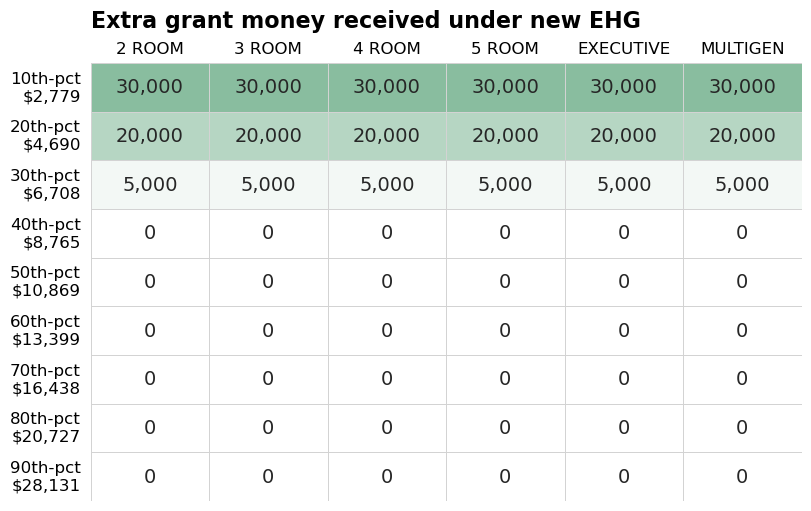

In [17]:
# modifying the seagreen palette to include white
modified_seagreen = list(sns.light_palette("seagreen", as_cmap=False))
modified_seagreen.insert(0, (1.0, 1.0, 1.0))
modified_seagreen_palette = LinearSegmentedColormap.from_list("mod_seagreen", modified_seagreen, N=256)


# creating the heatmap
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.heatmap(
    data=data,
    ax=ax,
    cmap=modified_seagreen_palette,
    linewidths=0.5,
    linecolor="lightgrey",
    vmin=0,         # mine colour map
    vmax=50000,     # max value of the colour map
    annot=data.map(lambda x: f"{x:,.0f}"),
    fmt="",         # Specify this if you are inserting strings
    cbar=None,      # omitting the colourbar since numbers are specified
    annot_kws={"size": 14, "ha": "center"},
)

# modifying x labels
xticklabs = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xticklabs, fontsize=12, fontdict={"verticalalignment": "baseline"})
ax.xaxis.tick_top()
ax.tick_params(top=False)
ax.set_facecolor("white")
# modifying y labels
yticklabs = [
    f"{(idx+1)*10}th-pct\n${val:,.0f}" for idx, val in enumerate(household_income_2023)
]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(yticklabs, rotation="horizontal", fontsize=12, ha="right")
ax.tick_params(left=False)

# remove x and y labels
ax.set_xlabel(None)         
ax.set_ylabel(None)

ax.set_title(
    "Extra grant money received under new EHG",
    size=16,
    loc="left",
    pad=10,
    weight="bold",
);

Interpretation:

This is rather surprising for me because I had originally expected the larger proportion of home buyers would benefit from the enhanced EHG. The visualisation shows the contrary. Not even the 1st income decile benefitted from the 40k increase in enhanced housing grant (EHG). Additional grants taper off to a mere 5K for the 3rd income decile.

## Q2: How much more upfront cost has to be borned by home owners with the lowering of 5% LTV limit?

We keep the prices of flats constant and study how new policies increases downpayment and increase grants.

For the purposes of this study, we make a few assumptions:
1. __Profile of the buyer:__ We assume that a soon-to-be-wedded couple (30 years old) taking a 25-year term loan. This maximises their LTV limit to 75%. There are [instances][propertyguru-info-on-ltv] where the LTV can be significantly below 75% (such having an existing home loan, etc.) and such scenarios will not be considered in this study.
2. __Grants__: The couple intends to purchase a flat in the resale market. This assumption allows the couple to reap the maximum grants given by the government. Other groups of people such as first-time home buyers who are single will not be studied here (they are given a lower amount of subsidy)
3. __Maximising LTV__: The couple will pay a downpayment of 25% and take a home loan from HDB at 2.6% interest rate per annum. Depending on an individual's financial situation, couples do have the option of lowering their bank loan and increasing their proportion of downpayment but such scenarios will not be studied here.  
4. __Interest rate__: The couple will take a HDB loan of with a 2.6% per annum interest and a payment term of 25 years. No early repayment is considered.
5. __OA, then out-of-pocket__: The couple is assumed to pay the HDB using their CPF-OA first, and any remainder will be paid using their disaposable income.

[propertyguru-info-on-ltv]: https://www.propertyguru.com.sg/property-guides/singapore-loan-to-value-ratio-guide-12845

In [18]:
def get_x_percentile_flat_price(df):
    # we find the mean price of flats only for the year 2024 (perhaps we can even restrict it to the past 1 month)
    data = df.query("year == 2024")
    data = data.groupby(["flat_type"])[["resale_price"]].agg(
        [
            lambda x: np.percentile(x, q=0),
            lambda x: np.percentile(x, q=10),
            lambda x: np.percentile(x, q=20),
            lambda x: np.percentile(x, q=30),
            lambda x: np.percentile(x, q=40),
            lambda x: np.percentile(x, q=50),
            lambda x: np.percentile(x, q=60),
            lambda x: np.percentile(x, q=70),
            lambda x: np.percentile(x, q=80),
            lambda x: np.percentile(x, q=90),
            lambda x: np.percentile(x, q=100),
        ]
    )

    data = data.droplevel(0, axis=1).reset_index()
    data = data.rename(
        columns={
            "<lambda_0>": "perc_000",
            "<lambda_1>": "perc_010",
            "<lambda_2>": "perc_020",
            "<lambda_3>": "perc_030",
            "<lambda_4>": "perc_040",
            "<lambda_5>": "perc_050",
            "<lambda_6>": "perc_060",
            "<lambda_7>": "perc_070",
            "<lambda_8>": "perc_080",
            "<lambda_9>": "perc_090",
            "<lambda_10>": "perc_100",
        }
    )
    
    result = data.set_index("flat_type")

    return result

In [19]:
flat_price_all_quantiles = get_x_percentile_flat_price(df)
flat_price_all_quantiles

,perc_000,perc_010,perc_020,perc_030,perc_040,perc_050,perc_060,perc_070,perc_080,perc_090,perc_100
flat_type,,,,,,,,,,,
1 ROOM,230000.0,230000.0,238000.0,241400.0,243800.0,246000.0,250200.0,258900.0,270400.0,282000.0,300000.0
2 ROOM,240000.0,290000.0,315000.0,325000.0,330888.0,340000.0,350000.0,355000.0,367600.0,380000.0,525000.0
3 ROOM,250000.0,348000.0,370000.0,383000.0,398888.0,415000.0,434000.0,458000.0,488000.0,548000.0,1568000.0
4 ROOM,350000.0,485000.0,512000.0,538000.0,560000.0,588000.0,615000.0,645672.0,709000.0,840000.0,1450000.0
5 ROOM,400000.0,580000.0,610000.0,635000.0,658000.0,688000.0,720000.0,760000.0,818000.0,924888.8,1588000.0
EXECUTIVE,595000.0,728400.0,770000.0,800000.0,830000.0,855000.0,880000.0,920000.0,966800.0,1034400.0,1500000.0
MULTI-GENERATION,980000.0,989000.0,998000.0,1013000.0,1028000.0,1028000.0,1028000.0,1044000.0,1060000.0,1130000.0,1200000.0


The dataframe lists flats prices of different flat types across all deciles. We will use the dataframe calculate the price difference in LTV for all flat types and all percentiles

In [20]:
def generate_basic_df():
    # the basic df contains income deciles, income, take-home-pay, and 
    deciles = range(1, 10)
    household_income_2023 = [2779, 4690, 6708, 8765, 10869, 13399, 16438, 20727, 28131]
    df = pd.DataFrame({"deciles": deciles, "household_income": household_income_2023})
    df["disposable_income"] = df["household_income"] * 0.8    # this is the take-home pay since 20% goes to CPF
    df["cpf-oa"] = df["household_income"] * 0.23              # 23% is allocated to the OA, which can be used to finance home loans. 8% to MA and 6% to SA for a total of 37%
    
    # note that allocation rates differ after 35 years old
    return df

# next, we retrieve the price of the flat according to the flat_type and decile
def get_price_by_flat_type_and_pct(row, flat_price_df):
    flat_type = row["flat_type"]
    percentile = row["percentile"]

    return flat_price_df.loc[flat_type, percentile]


# next, we insert the amount of subsidy that first-time home owners can enjoy based on old and new grant figures
def modified_calculate_housing_grant(row, new_calc, proximity=False):
    # note that the definition income ceiling does not restrict you from purchasing
    # a resale flat. You will just get a smaller-sized grant
    income = row["household_income"]
    flat_type = row["flat_type"]

    # reminder: i am capping the proximity grant to 20k since the whole point
    # for first-time families to purchase a flat is to move out of parents' houses
    prox = proximity_housing_grant(proximity)
    cpf_hg = housing_grant(flat_type)

    if new_calc:
        ehg = new_enhanced_housing_grant(income)
    else:
        ehg = old_enhanced_housing_grant(income)

    if income <= 14_000:
        # total grant is the summation of proximity grant, cpf grant, and enhanced cpf grant
        result = int(prox + cpf_hg + ehg)
        return result
    else:
        return prox


def monthly_amortised_payments(total_loan, interest, n_years):
    """
    Calculates the monthly payments given the loan quamtum, interest, and number of years.
    I am not applying it to row since there are 2 monthly mortgages to calculate under the old and new policy
    """
    interest = (interest / 100) / 12
    n_payments = n_years * 12
    result = total_loan * (
        (interest * (1 + interest) ** n_payments) / ((1 + interest) ** n_payments - 1)
    )
    return result


# note: a step-by-step guide to how the dataframe is constructed can be found in the supplementary calculations section
def create_combined_dataset(choose_percentile):
    all_dataframes = []
    for flat_type in ['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE','MULTI-GENERATION']:
        for percentile in ['perc_000', 'perc_010', 'perc_020', 'perc_030', 'perc_040', 'perc_050', 'perc_060','perc_070', 'perc_080', 'perc_090', 'perc_100']:
            df = generate_basic_df()

            # define the percentile and flat type
            df["flat_type"] = flat_type
            df["percentile"] = percentile

            # retrieve the flat_price based on percentile and flat type
            df["flat_price"] = df.apply(get_price_by_flat_type_and_pct, axis=1, flat_price_df=flat_price_all_quantiles)

            # calculate the amount of grants provided to the home buyer
            df["old_grants"] = df.apply(modified_calculate_housing_grant, axis=1, new_calc=False)
            df["new_grants"] = df.apply(modified_calculate_housing_grant, axis=1, new_calc=True)

            df["grants_diff"] = df["new_grants"] - df["old_grants"]

            # calculate the price of flat after grants
            df["flat_price_after_grants_old"] = df["flat_price"] - df["old_grants"]
            df["flat_price_after_grants_new"] = df["flat_price"] - df["new_grants"]

            # calculate the downpayment cost under the old and new policies
            # old policy: LTV 80%, EHG 80,000
            # new policy: LTV 75%, EHG 120,000
            df["cash_balance_old"] = df["flat_price_after_grants_old"] * 0.20
            df["cash_balance_new"] = df["flat_price_after_grants_new"] * 0.25

            # calculate the difference in downpayment
            df["cash_balance_difference"] = df["cash_balance_new"] - df["cash_balance_old"]

            # calculate calculate loan under old and new policies
            df["home_loan_old"] = df["flat_price_after_grants_old"] * 0.80
            df["home_loan_new"] = df["flat_price_after_grants_new"] * 0.75

            # calculate monthly payments amortised over 25 years at 2.6% interest pa.
            df["monthly_payment_old"] = df["home_loan_old"].apply(lambda x: monthly_amortised_payments(x, 2.6, 25))
            df["monthly_payment_new"] = df["home_loan_new"].apply(lambda x: monthly_amortised_payments(x, 2.6, 25))

            # calculate the difference in monthly payments
            df["monthly_payment_diff"] = df["monthly_payment_new"] - df["monthly_payment_old"]
            
            # calculate out of pocket payment. We default to using CPF to pay
            df['out_of_pocket_old'] = (df["monthly_payment_old"] - df["cpf-oa"]).apply(lambda x: x if x > 0 else 0)
            df['out_of_pocket_new'] = (df["monthly_payment_new"] - df["cpf-oa"]).apply(lambda x: x if x > 0 else 0)
            
            df["out_of_pocket_diff"] = df["out_of_pocket_new"] - df['out_of_pocket_old']
            
            df['price_income_ratio_old'] = df['out_of_pocket_old'] / df['disposable_income']
            df['price_income_ratio_new'] = df['out_of_pocket_new'] / df['disposable_income']

            all_dataframes.append(df)

    result = pd.concat(all_dataframes, axis=0)
    result = result.query("percentile == @choose_percentile")
    return result


def retrieve_pivot_table_and_flat_values_for_a_given_percentile(df, choose_percentile):
    pivot_table = create_combined_dataset(choose_percentile)

    flat_price_df = get_x_percentile_flat_price(df)
    flat_price_percentile = flat_price_df.loc[:, choose_percentile]
    
    return pivot_table, flat_price_percentile

### Flat Prices at the 50th Percentile

In [21]:
pivot_table_pct, flat_prices_pct = retrieve_pivot_table_and_flat_values_for_a_given_percentile(df, choose_percentile="perc_050") 

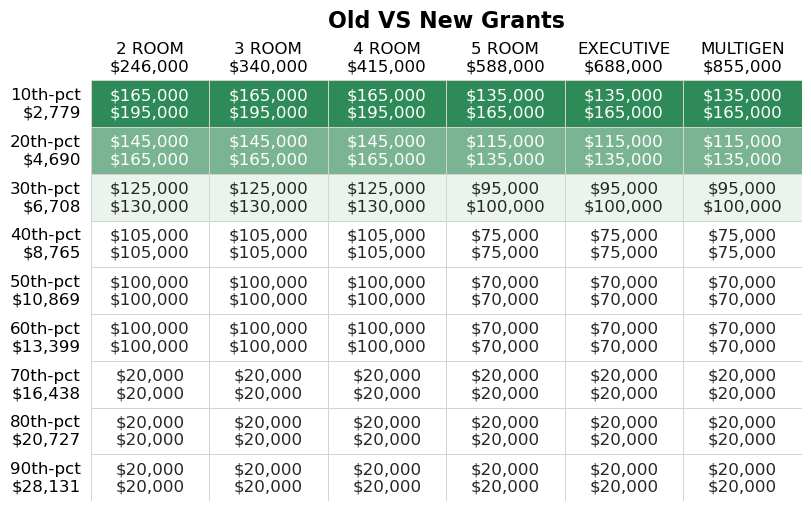

In [22]:
grants_old = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values="old_grants")
grants_new = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values="new_grants")
grants_comb = pd.concat([grants_old, grants_new]).groupby(level=0).agg(list)
heatmap_labels = grants_comb.map(lambda x: f"${x[0]:,.0f}\n${x[1]:,.0f}")

grants_diff = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values="grants_diff")

# creating the heatmap
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.heatmap(
    data=grants_diff,
    ax=ax,
    cmap=modified_seagreen_palette,
    linewidths=0.5,
    linecolor="lightgrey",
    vmin=0,
    annot=heatmap_labels,
    fmt="",  # Specify this if you are inserting strings
    cbar=None,  # omitting the colourbar since numbers are specified
    annot_kws={"size": 12, "ha": "center"},
)

# modifying x labels
flat_type = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
flat_median_price =flat_prices_pct.values
xticklabs = [f"{x}\n${y:,.0f}" for x, y in zip(flat_type, flat_median_price)]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xticklabs, fontsize=12, fontdict={"verticalalignment": "baseline"})
ax.xaxis.tick_top()
ax.tick_params(top=False)
ax.set_facecolor("white")

# modifying y labels
yticklabs = [
    f"{(idx+1)*10}th-pct\n${val:,.0f}" for idx, val in enumerate(household_income_2023)
]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(yticklabs, rotation="horizontal", fontsize=12, ha="right")
ax.tick_params(left=False)

# remove x and y labels
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_title(
    "Old VS New Grants",
    size=16,
    loc="center",
    pad=10,
    weight="bold",
); # include semicolon to suppress text printed in the output

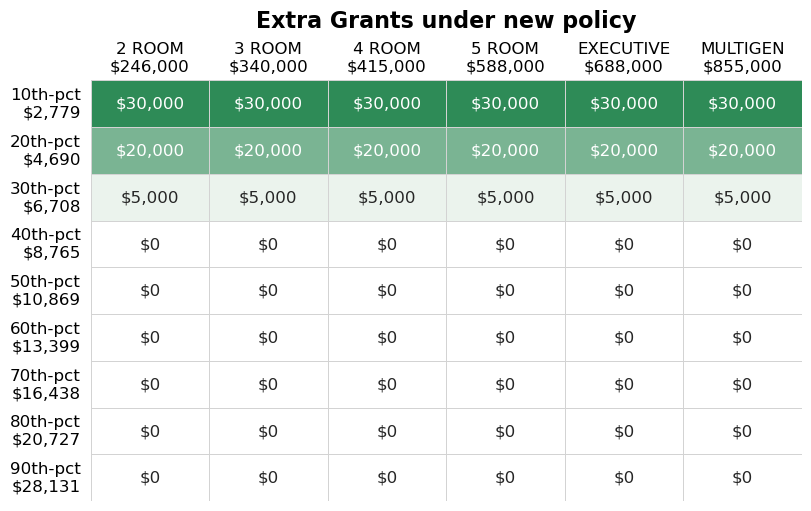

In [23]:
grants_diff = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values="grants_diff")

# creating the heatmap
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.heatmap(
    data=grants_diff,
    ax=ax,
    cmap=modified_seagreen_palette,
    linewidths=0.5,
    linecolor="lightgrey",
    vmin=0,
    annot=grants_diff.map(lambda x: f"${x:,.0f}" if x > 0 else "$0"),
    fmt="",  # Specify this if you are inserting strings
    cbar=None,  # omitting the colourbar since numbers are specified
    annot_kws={"size": 12, "ha": "center"},
)

# modifying x labels
flat_type = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
flat_median_price =flat_prices_pct.values
xticklabs = [f"{x}\n${y:,.0f}" for x, y in zip(flat_type, flat_median_price)]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xticklabs, fontsize=12, fontdict={"verticalalignment": "baseline"})
ax.xaxis.tick_top()
ax.tick_params(top=False)
ax.set_facecolor("white")

# modifying y labels
yticklabs = [
    f"{(idx+1)*10}th-pct\n${val:,.0f}" for idx, val in enumerate(household_income_2023)
]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(yticklabs, rotation="horizontal", fontsize=12, ha="right")
ax.tick_params(left=False)

# remove x and y labels
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_title(
    "Extra Grants under new policy",
    size=16,
    loc="center",
    pad=10,
    weight="bold",
);

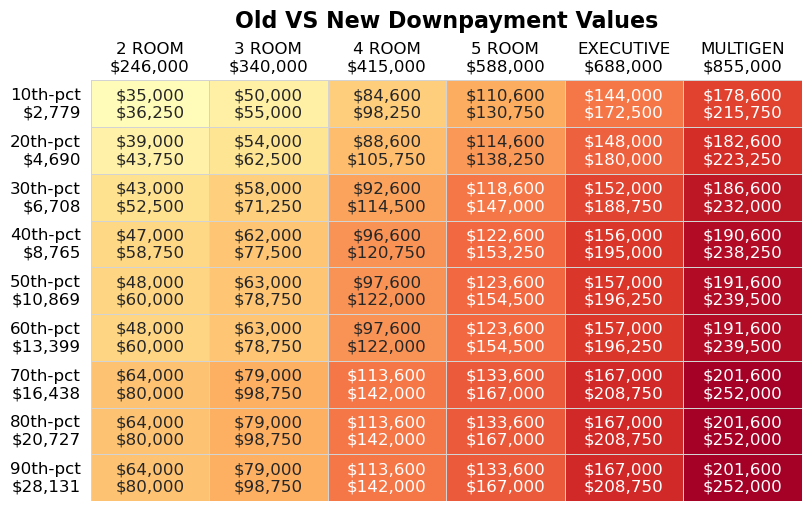

In [24]:
downpayment_old = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["cash_balance_old"]).droplevel(level=0, axis=1)
downpayment_new = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["cash_balance_new"]).droplevel(level=0, axis=1)
downpayment_comb = pd.concat([downpayment_old, downpayment_new]).groupby(level=0).agg(list)
heatmap_labels = downpayment_comb.map(lambda x: f"${x[0]:,.0f}\n${x[1]:,.0f}")

downpayment_diff = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["cash_balance_difference"])

red_yellow_green_palette = sns.color_palette("RdYlGn_r", as_cmap=True)

# creating the heatmap
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.heatmap(
    data=downpayment_diff,
    ax=ax,
    cmap=red_yellow_green_palette,
    linewidths=0.5,
    linecolor="lightgrey",
    center=0,
    annot=heatmap_labels,
    fmt="",  # Specify this if you are inserting strings
    cbar=None,  # omitting the colourbar since numbers are specified
    annot_kws={"size": 12, "ha": "center"},
)

# modifying x labels
flat_type = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
flat_median_price =flat_prices_pct.values
xticklabs = [f"{x}\n${y:,.0f}" for x, y in zip(flat_type, flat_median_price)]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xticklabs, fontsize=12, fontdict={"verticalalignment": "baseline"})
ax.xaxis.tick_top()
ax.tick_params(top=False)
ax.set_facecolor("white")

# modifying y labels
yticklabs = [
    f"{(idx+1)*10}th-pct\n${val:,.0f}" for idx, val in enumerate(household_income_2023)
]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(yticklabs, rotation="horizontal", fontsize=12, ha="right")
ax.tick_params(left=False)

# remove x and y labels
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_title(
    "Old VS New Downpayment Values",
    size=16,
    loc="center",
    pad=10,
    weight="bold",
);

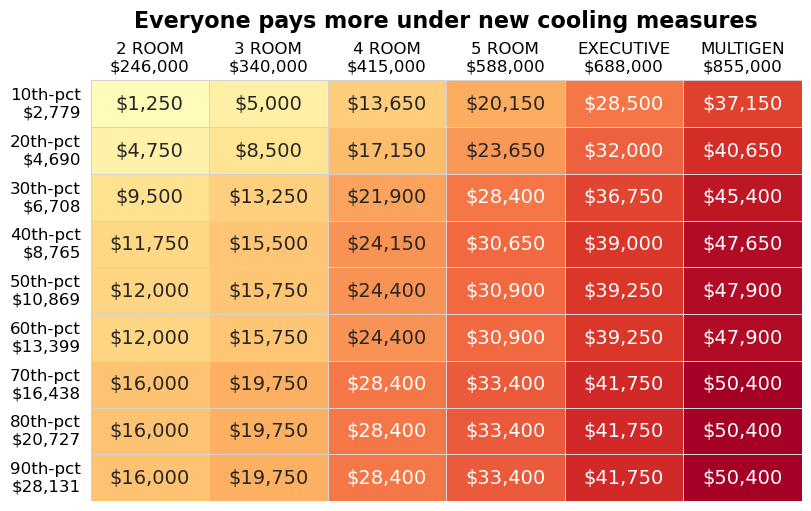

In [25]:
for_plotting_df = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["cash_balance_difference"])

red_yellow_green_palette = sns.color_palette("RdYlGn_r", as_cmap=True)


# creating the heatmap
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.heatmap(
    data=for_plotting_df,
    ax=ax,
    cmap=red_yellow_green_palette,
    linewidths=0.5,
    linecolor="lightgrey",
    center=0,
    annot=for_plotting_df.map(lambda x: f"${x:,.0f}"),
    fmt="",  # Specify this if you are inserting strings
    cbar=None,  # omitting the colourbar since numbers are specified
    annot_kws={"size": 14, "ha": "center"},
)

# modifying x labels
flat_type = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
flat_prices = flat_prices_pct.values
xticklabs = [f"{x}\n${y:,.0f}" for x, y in zip(flat_type, flat_prices)]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xticklabs, fontsize=12, fontdict={"verticalalignment": "baseline"})
ax.xaxis.tick_top()
ax.tick_params(top=False)
ax.set_facecolor("white")

# modifying y labels
yticklabs = [
    f"{(idx+1)*10}th-pct\n${val:,.0f}" for idx, val in enumerate(household_income_2023)
]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(yticklabs, rotation="horizontal", fontsize=12, ha="right")
ax.tick_params(left=False)

# remove x and y labels
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_title(
    "Everyone pays more under new cooling measures",
    size=16,
    loc="center",
    pad=10,
    weight="bold",
);

Note that my values are quite different from that published in the straits times. Perhaps my calculations are erroneous and if so, please leave a comment to inform me where has my calculations gone awry.

<img src='https://static1.straitstimes.com.sg/s3fs-public/articles/2024/08/21/ltv-FB-WA_1.jpg?VersionId=EUGkc2bzUVSgPO3W1boOXCV9wl5XdX6G' width='50%'>


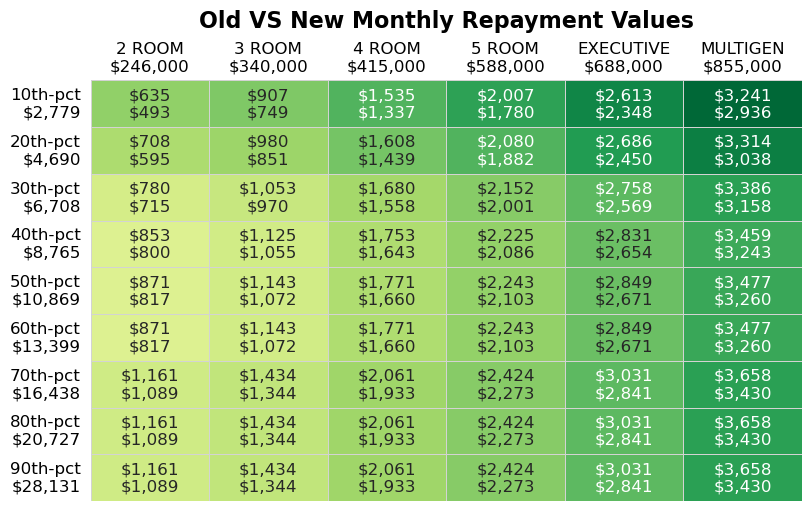

In [26]:
monthly_payment_old = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["monthly_payment_old"]).droplevel(level=0, axis=1)
monthly_payment_new = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["monthly_payment_new"]).droplevel(level=0, axis=1)
monthly_payment_comb = pd.concat([monthly_payment_old, monthly_payment_new]).groupby(level=0).agg(list)
heatmap_labels = monthly_payment_comb.map(lambda x: f"${x[0]:,.0f}\n${x[1]:,.0f}")

monthly_payment_diff = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["monthly_payment_diff"])

red_yellow_green_palette = sns.color_palette("RdYlGn_r", as_cmap=True)

# creating the heatmap
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.heatmap(
    data=monthly_payment_diff,
    ax=ax,
    cmap=red_yellow_green_palette,
    linewidths=0.5,
    linecolor="lightgrey",
    center=0,
    annot=heatmap_labels,
    fmt="",  # Specify this if you are inserting strings
    cbar=None,  # omitting the colourbar since numbers are specified
    annot_kws={"size": 12, "ha": "center"},
)

# modifying x labels
flat_type = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
flat_median_price =flat_prices_pct.values
xticklabs = [f"{x}\n${y:,.0f}" for x, y in zip(flat_type, flat_median_price)]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xticklabs, fontsize=12, fontdict={"verticalalignment": "baseline"})
ax.xaxis.tick_top()
ax.tick_params(top=False)
ax.set_facecolor("white")

# modifying y labels
yticklabs = [
    f"{(idx+1)*10}th-pct\n${val:,.0f}" for idx, val in enumerate(household_income_2023)
]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(yticklabs, rotation="horizontal", fontsize=12, ha="right")
ax.tick_params(left=False)

# remove x and y labels
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_title(
    "Old VS New Monthly Repayment Values",
    size=16,
    loc="center",
    pad=10,
    weight="bold",
);

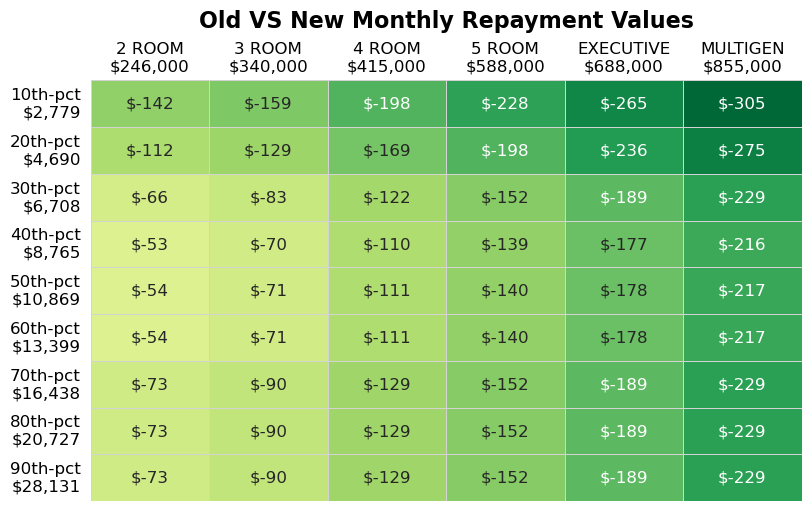

In [27]:
monthly_payment_diff = pivot_table_pct.pivot_table(index='household_income', columns='flat_type', values=["monthly_payment_diff"])

red_yellow_green_palette = sns.color_palette("RdYlGn_r", as_cmap=True)

# creating the heatmap
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
sns.heatmap(
    data=monthly_payment_diff,
    ax=ax,
    cmap=red_yellow_green_palette,
    linewidths=0.5,
    linecolor="lightgrey",
    center=0,
    annot=monthly_payment_diff.map(lambda x: f"${x:,.0f}"),
    fmt="",  # Specify this if you are inserting strings
    cbar=None,  # omitting the colourbar since numbers are specified
    annot_kws={"size": 12, "ha": "center"},
)

# modifying x labels
flat_type = ["2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTIGEN"]
flat_median_price =flat_prices_pct.values
xticklabs = [f"{x}\n${y:,.0f}" for x, y in zip(flat_type, flat_median_price)]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xticklabs, fontsize=12, fontdict={"verticalalignment": "baseline"})
ax.xaxis.tick_top()
ax.tick_params(top=False)
ax.set_facecolor("white")

# modifying y labels
yticklabs = [
    f"{(idx+1)*10}th-pct\n${val:,.0f}" for idx, val in enumerate(household_income_2023)
]
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(yticklabs, rotation="horizontal", fontsize=12, ha="right")
ax.tick_params(left=False)

# remove x and y labels
ax.set_xlabel(None)
ax.set_ylabel(None)

ax.set_title(
    "Old VS New Monthly Repayment Values",
    size=16,
    loc="center",
    pad=10,
    weight="bold",
);

Intepretation: 

Impact to monthly repayments is minimal 

# Supporting Calculations

In [28]:
# calulate 3-month moving average (proportion of million-dollar flats)

### Dataframe manipulation
# count the number of million dollar flats transacted per month
data_million = df.query("resale_price >= 1_000_000 & year >= 2023")
data_million = data_million.groupby([pd.Grouper(key='month', freq='ME')])[['resale_price']].agg('count')
data_million = data_million.rename(columns={'resale_price':'num_trans_mil'})
data_million["million_moving_avg_3mth"] = data_million.rolling(window=3).mean()

# count the number of flats transacted for each month
data_total = df.query("year >= 2023")
data_total = data_total.groupby([pd.Grouper(key='month', freq='ME')])[['resale_price']].agg('count')
data_total = data_total.rename(columns={"resale_price": "num_trans"})
data_total["total_moving_avg_3mth"] = data_total.rolling(window=3).mean()

# merge the 2 dataframes and find the proportion
data_comb = data_million.merge(data_total, left_index=True, right_index=True)
data_comb['prop_million'] = np.round(data_comb["num_trans_mil"] / data_comb["num_trans"] * 100, 2)
data_comb["pct_chg_prop_mil"] = data_comb["prop_million"].pct_change() * 100
data_comb["pct_chg_prop_mil_display"] = data_comb["pct_chg_prop_mil"].apply(lambda x: f"{x:,.2f}" if pd.notna(x) else "-")
data_comb['prop_million_ma3'] = np.round(data_comb["million_moving_avg_3mth"] / data_comb["total_moving_avg_3mth"] * 100, 2)

data_comb

,num_trans_mil,million_moving_avg_3mth,num_trans,total_moving_avg_3mth,prop_million,pct_chg_prop_mil,pct_chg_prop_mil_display,prop_million_ma3
month,,,,,,,,
2023-01-31,40,NaN,2551,NaN,1.57,NaN,-,NaN
2023-02-28,24,NaN,1837,NaN,1.31,-16.560510,-16.56,NaN
2023-03-31,39,34.333333,2277,2221.666667,1.71,30.534351,30.53,1.55
2023-04-30,37,33.333333,2177,2097.000000,1.70,-0.584795,-0.58,1.59
2023-05-31,34,36.666667,2245,2233.000000,1.51,-11.176471,-11.18,1.64
2023-06-30,34,35.000000,1853,2091.666667,1.83,21.192053,21.19,1.67
2023-07-31,32,33.333333,2052,2050.000000,1.56,-14.754098,-14.75,1.63
2023-08-31,54,40.000000,2467,2124.000000,2.19,40.384615,40.38,1.88
2023-09-30,42,42.666667,1974,2164.333333,2.13,-2.739726,-2.74,1.97


In [29]:
## Testing housing grant calculation
def calculate_housing_grant_test(income, flat_type, new_calc, proximity=False):
    # note that the definition income ceiling does not restrict you from purchasing
    # a resale flat. You will just get a smaller-sized subsidy

    prox = proximity_housing_grant(proximity)
    cpf_hg = housing_grant(flat_type)

    if new_calc:
        ehg = new_enhanced_housing_grant(income)
    else:
        ehg = old_enhanced_housing_grant(income)

    print(prox, cpf_hg, ehg)

    if income <= 14_000:
        # total grant is the summation of proximity grant, cpf grant, and enhanced cpf grant
        result = int(prox + cpf_hg + ehg)
        return result
    else:
        return prox

print(calculate_housing_grant_test(6708, "2 ROOM", True))
print(calculate_housing_grant_test(6708, "2 ROOM", False))

20000 80000 30000
130000
20000 80000 25000
125000


In [30]:
### Dataframe manipulation
# count the number of million dollar flats transacted per month
data_million = df.query("resale_price >= 1_000_000 & year >= 2023")
data_million = data_million.groupby([pd.Grouper(key='month', freq='ME')])[['resale_price']].agg('count')
data_million = data_million.rename(columns={'resale_price':'num_trans_mil'})

# count the number of flats transacted for each month
data_total = df.query("year >= 2023")
data_total = data_total.groupby([pd.Grouper(key='month', freq='ME')])[['resale_price']].agg('count')
data_total = data_total.rename(columns={"resale_price": "num_trans"})

# merge the 2 dataframes and find the proportion
data_comb = data_million.merge(data_total, left_index=True, right_index=True)
data_comb['prop_million'] = np.round(data_comb["num_trans_mil"] / data_comb["num_trans"] * 100, 2)
data_comb["pct_chg_prop_mil"] = data_comb["prop_million"].pct_change() * 100
data_comb["pct_chg_prop_mil_display"] = data_comb["pct_chg_prop_mil"].apply(lambda x: f"{x:,.2f}" if pd.notna(x) else "-")

data_comb = data_comb.reset_index()

# the number of million-dollar transactions for the past 18 months
data_comb.loc[1:18, "num_trans_mil"].sum() / data_comb.loc[1:18, "num_trans"].sum()

0.02416254805052169